# Preparing the Dataset

Now that we have successfully imported the C04B21 dual-energy CT dataset 
in the previous part of the tutorial, we can proceed with preparing the 
dataset for the Monte Carlo inversion. In this part, we will perform the 
necessary pre-processing steps to get the data ready, which include:

   - Creating the dual-energy class instance.
   - Importing the original images.
   - Assigning a mask and specifying the standard properties.
   - Running the pre-processing step to generate the inversion coefficients.
   - Performing appraisal.

## Start a parallel MPI cluster

In this tutorial, we will process data directly within the Jupyter Notebook, 
in a parallel MPI (Message Passing Interface) environment using 
[ipyparallel](https://ipyparallel.readthedocs.io/).

The machine used in this tutorial has 8 GPUs available, which will significantly 
enhance processing speed due to the parallel computation capabilities of RockVerse. 
Let's create a cluster with a set of 8 MPI engines. RockVerse will automatically 
assign one MPI process to each GPU.


In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 8 engines
cluster = ipp.Cluster(engines="mpi", n=8)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

## Create the Dual Energy group and import the CT images

Next, let's create the dual energy group and copy the images we 
imported [in the previous part of this tutorial](./dual_energy_tutorial_download_data.ipynb). 

The ``copy_image`` method below will create a new image in the Zarr store, giving us the 
opportunity to change the chunk size. Monte Carlo dual energy processing utilizes all 
MPI processes to share the load of each individual chunk. Once processing for each chunk 
is finished, RockVerse will write a checkpoint to the file system, allowing the 
simulation to be resumed in case it crashes midway.

Therefore, prefer smaller chunks if you want frequent checkpoints, but not so small that the 
read/write overhead becomes considerable. Considering our image shape and the 8 available GPUs,
we'll copy the original CT scans creating 16 chunks.

In [ ]:
%%px --block

import matplotlib.pyplot as plt
from IPython.display import display
import rockverse as rv

# Create the Dual Energy CT group
dectgroup = rv.dect.create_group(
    store='/path/to//dual_energy_ct/C04B21')

# Copy the low energy CT image
dectgroup.copy_image(
    image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw100keV'),
    name='lowECT',
    chunks=16)

# Copy the high energy CT image
dectgroup.copy_image(
    image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw140keV'),
    name='highECT',
    chunks=16)


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-08-08 11:04:25] Copying: 100% 16/16 [00:03<00:00,  5.28chunk/s]
[2025-08-08 11:04:28] Copying: 100% 16/16 [00:02<00:00,  5.36chunk/s]


Now, let's take a quick look at the data using the orthogonal viewer:

[stdout:0] [2025-08-08 11:04:32] Histogram Low energy attenuation (min/max): 100% 16/16 [00:00<00:00, 90.27chunk/s]
[2025-08-08 11:04:32] Histogram Low energy attenuation (counting voxels): 100% 16/16 [00:02<00:00,  6.34chunk/s]
[2025-08-08 11:04:38] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 87.26chunk/s]
[2025-08-08 11:04:38] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:01<00:00,  9.37chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

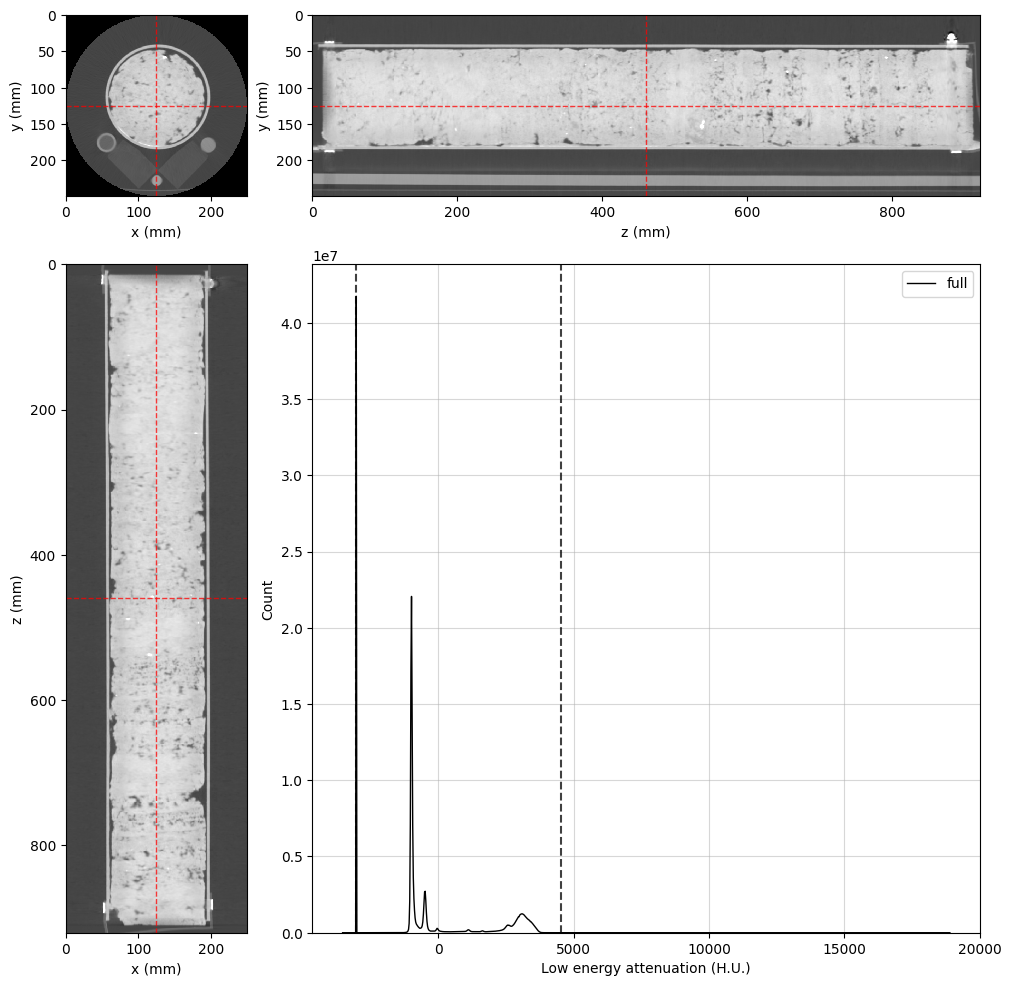

[output:0]

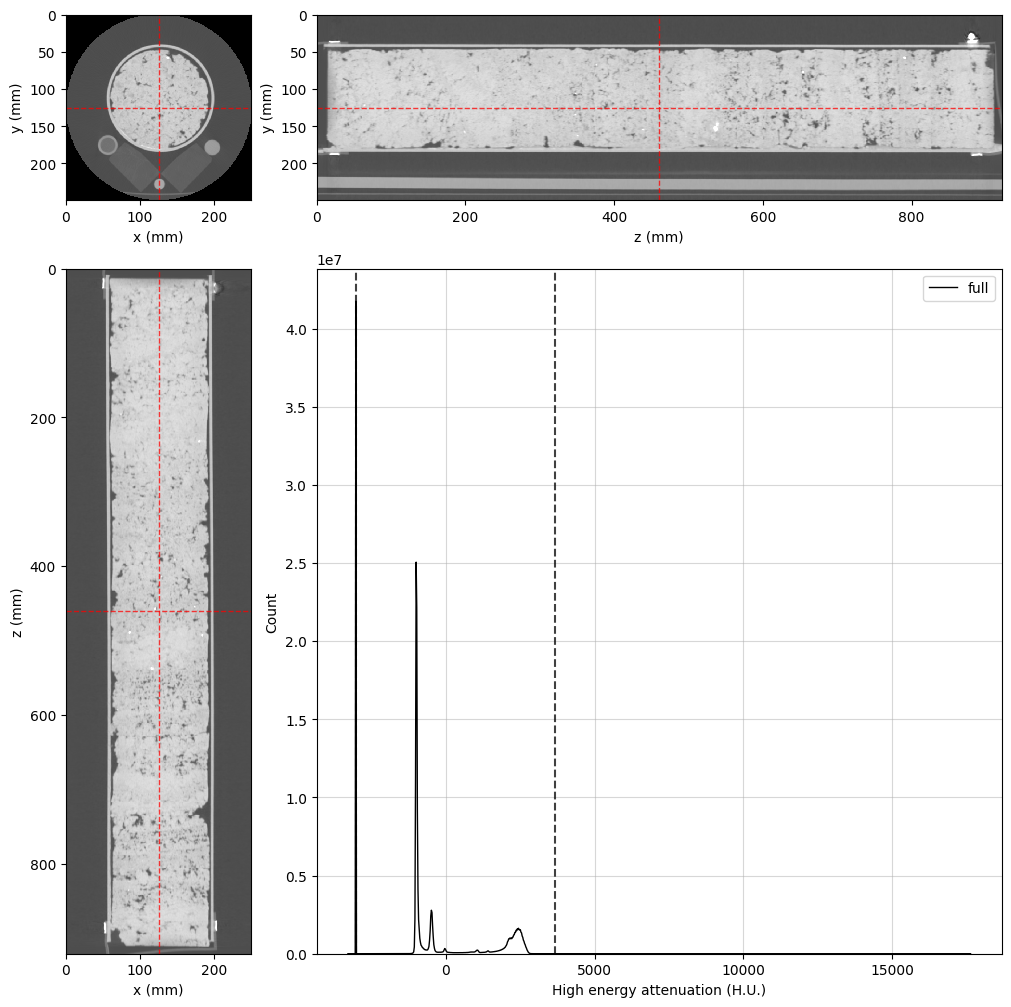

In [3]:
%%px --block

# Create orthogonal viewers for low and high energy images
lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, histogram_bins=2**10)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, histogram_bins=2**10)

# Matplotlib's figure object can be accessed through
# the figure property in the orthogonal viewer.
# Let's increase the figure size
lowE_viewer.figure.set_size_inches(10, 10)
highE_viewer.figure.set_size_inches(10, 10)

# Each process will create its own repeated image,
# let's close all but rank zero:
if rv.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)

## Intermediate step (optional): perform image segmentation

Now that the original CT images have been successfully imported, the next step is to define a mask. The mask helps optimize computational resources by excluding voxels that are not relevant to our analysis. Additionally, we need to provide information about the calibration materials, namely compositions and probability density functions for the X-ray attenuation. 

This information comes from image segmentation. If a segmentation or a mask image have already been created elsewhere, you can use the ``copy_image`` method to import them  (refer to the API documentation for detailed instructions). However, the original dataset from the Digital Rocks Portal does not include this information. Nevertheless, the rock sample and the standard materials are reasonably aligned with the image's z-axis. Let's quickly build a (not very accurate but useful for our tutorial...) segmentation image using RockVerse's cylindrical regions. A little trial and error is all it takes in our case:

.. note:
    In your real world inversions, ensure that proper segmentation and statistical analysis of X-ray attenuation for calibration materials are performed.
    
### Air Region

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-08-08 11:04:50] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 24.18chunk/s]
[2025-08-08 11:04:50] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 65.47chunk/s]


[output:0]

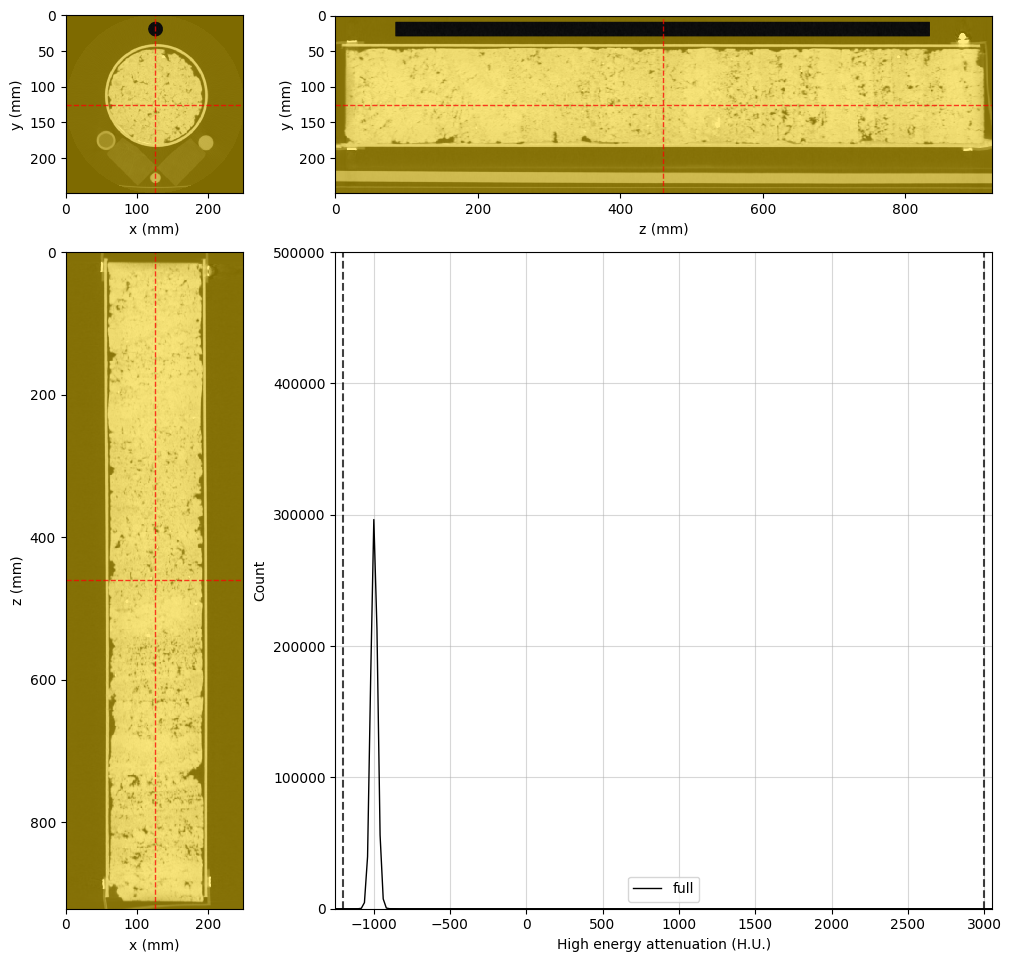

In [4]:
%%px --block

# Adjusting viewer properties will help us in this task
highE_viewer.update_image_dict(clim=(-1200, 3000))
highE_viewer.mask_color = 'gold'
highE_viewer.mask_alpha = 0.5

# This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)

# Set the region in the viewer and visualize the result
highE_viewer.region = air_region

# Changing region rebuilds the histogram. Let's set scales again
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 5e5)

# Only display the figure for rank 0
if rv.mpi_rank == 0:
    display(highE_viewer.figure)

### Water region

[stdout:0] [2025-08-08 11:04:54] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 28.98chunk/s]
[2025-08-08 11:04:54] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 66.76chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

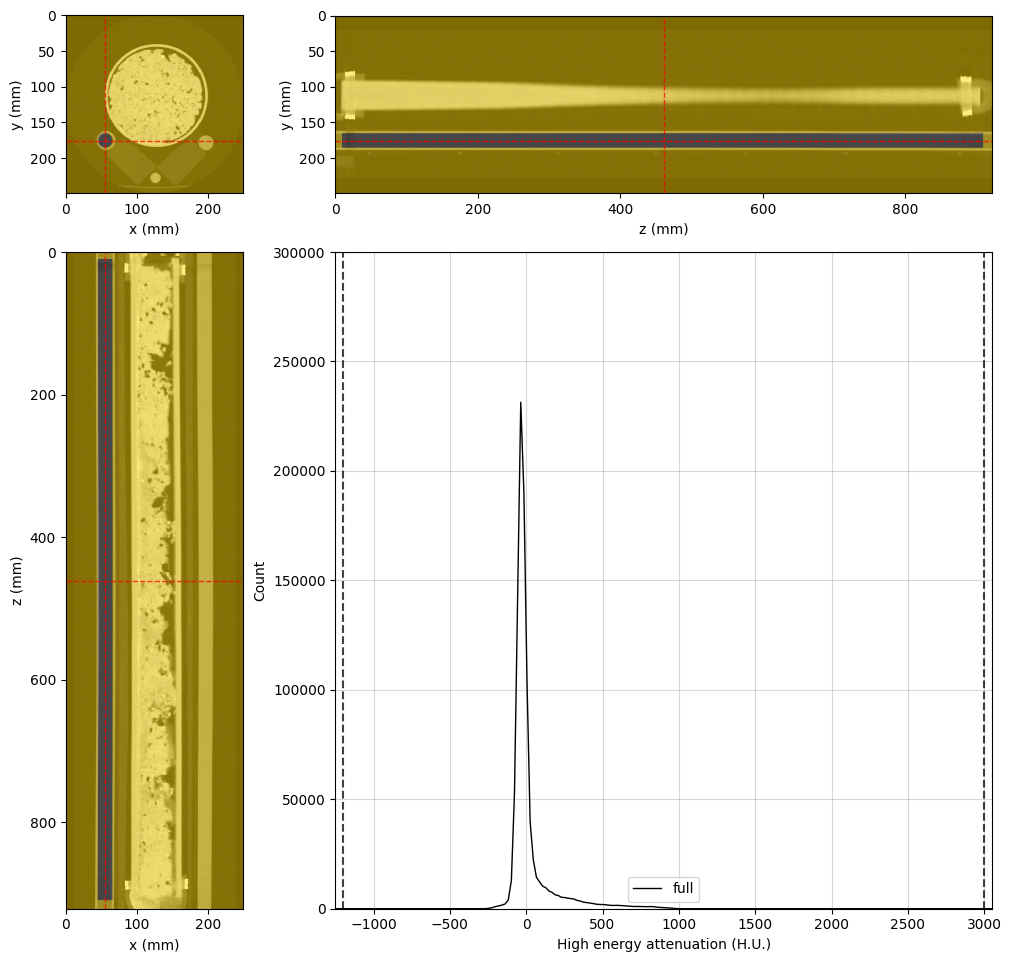

In [5]:
%%px --block

# Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = water_region
highE_viewer.ref_point = water_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 3e5)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)

### Silica region

[stdout:0] [2025-08-08 11:04:59] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 28.11chunk/s]
[2025-08-08 11:05:00] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 67.90chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

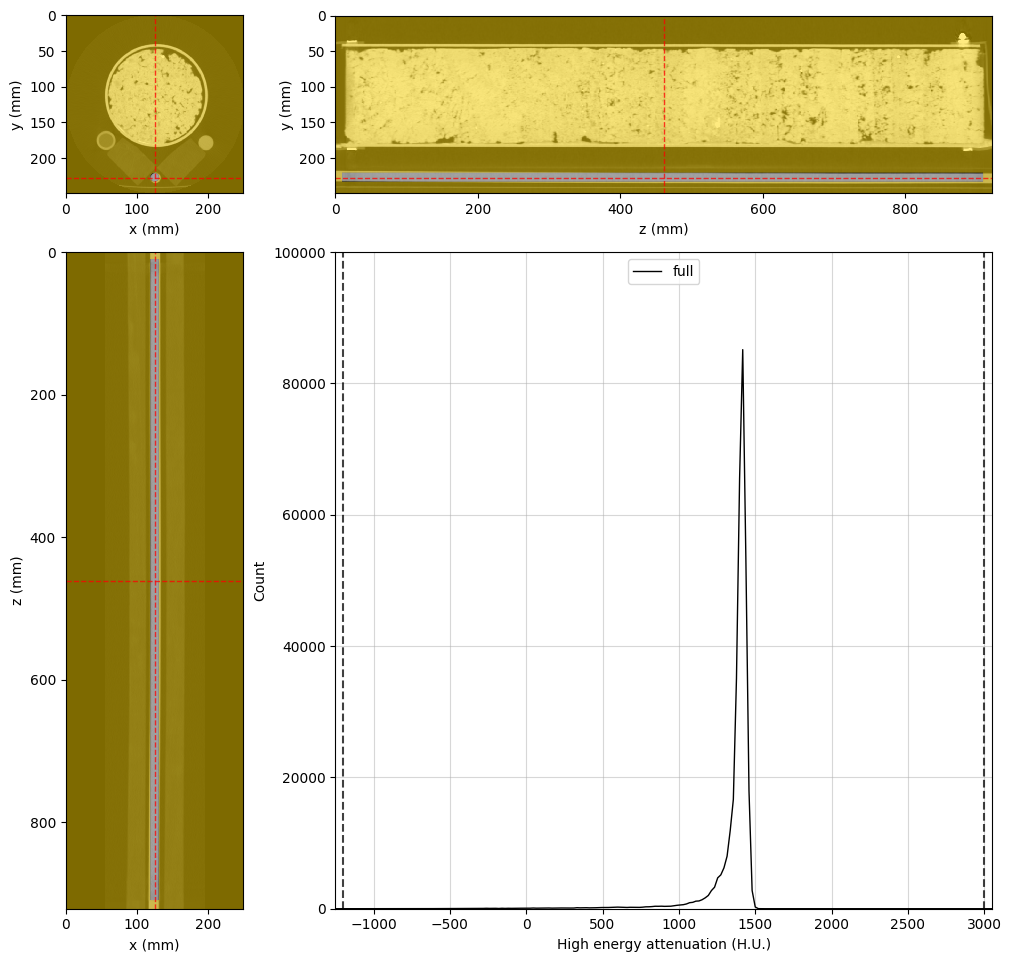

In [6]:
%%px --block

# Final silica region
silica_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = silica_region
highE_viewer.ref_point = silica_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 1e5)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)

### Teflon region

[stdout:0] [2025-08-08 11:05:05] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 28.60chunk/s]
[2025-08-08 11:05:05] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 71.39chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

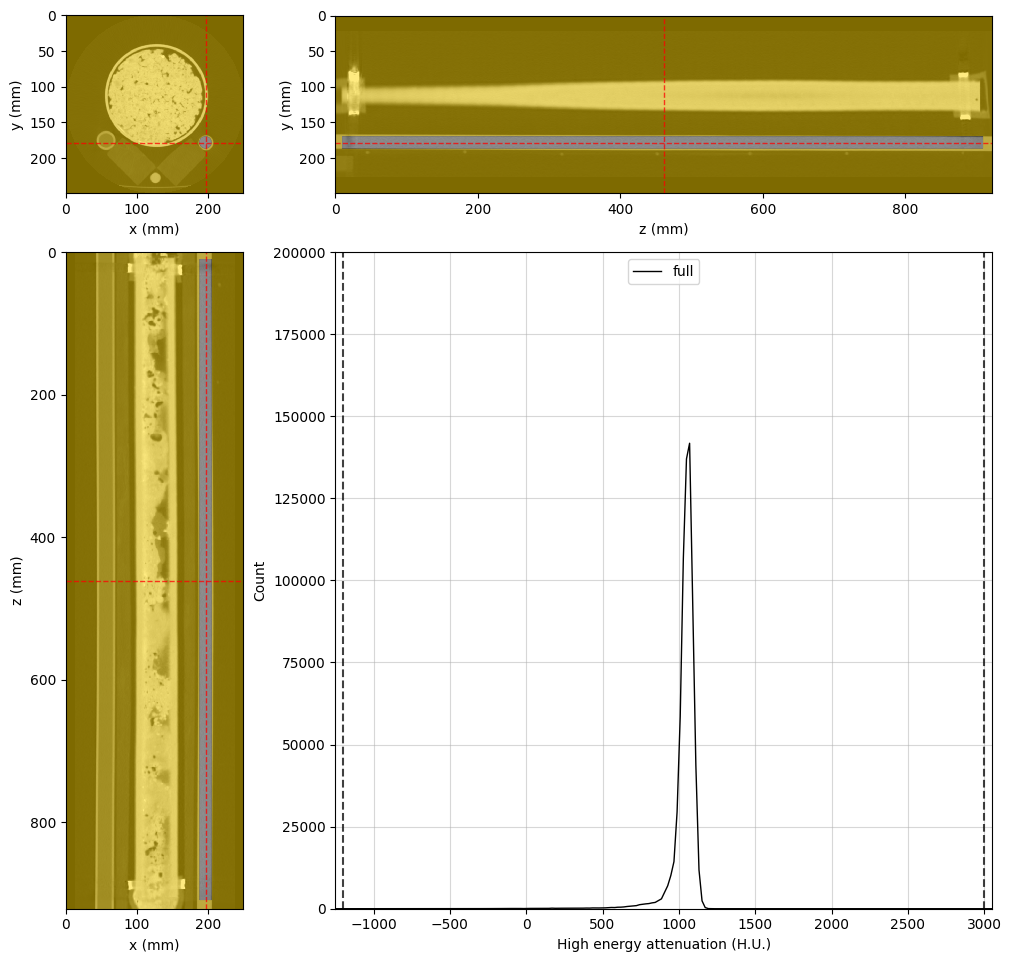

In [7]:
%%px --block

# Final teflon region
teflon_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=8.5, l=900)

# Adjust the viewer and display for rank 0
highE_viewer.region = teflon_region
highE_viewer.ref_point = teflon_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2e5)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)

### Rock sample region

[stdout:0] [2025-08-08 11:05:10] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 22.36chunk/s]
[2025-08-08 11:05:11] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 18.45chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

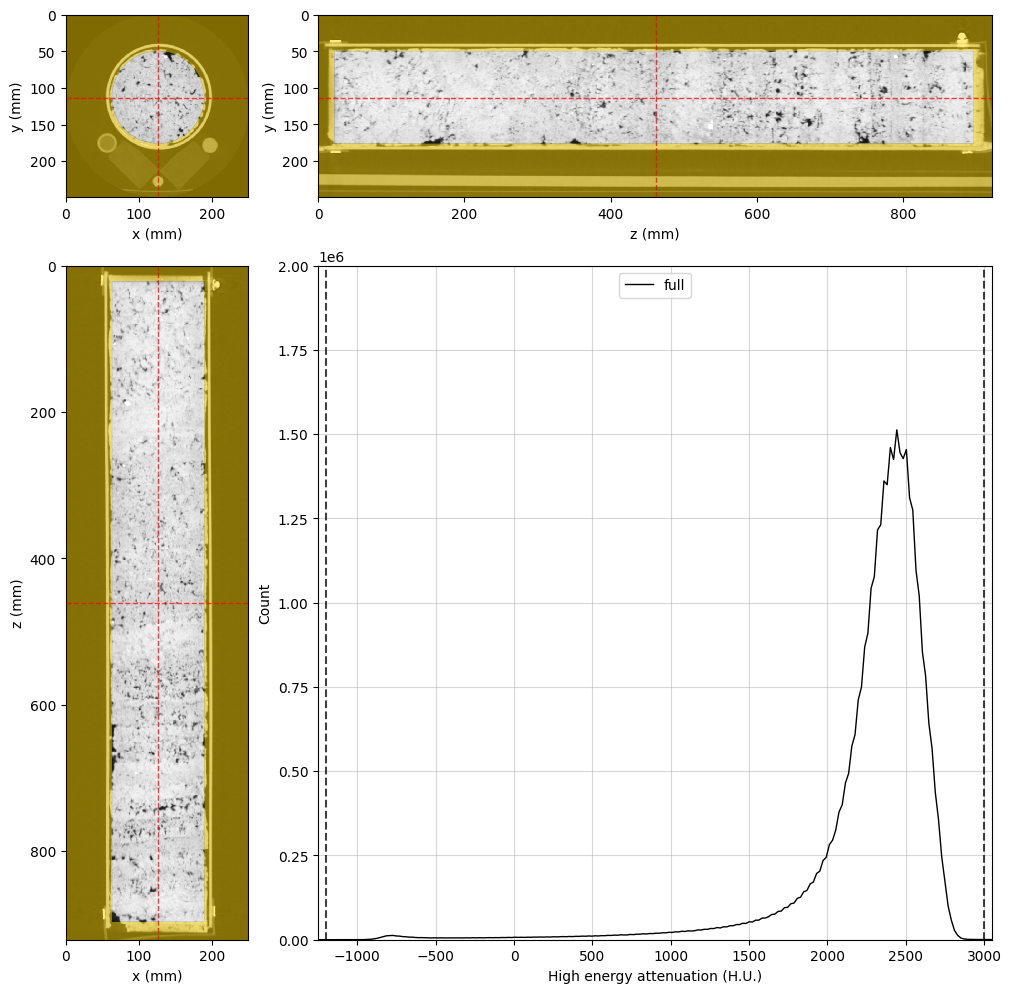

In [8]:
%%px --block --group-outputs=type

# Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)

# Adjust the viewer and display for rank 0
highE_viewer.region = rock_region
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2e6)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

[stdout:0] [2025-08-08 11:05:16] (segmentation) Set: 100% 16/16 [00:03<00:00,  5.25chunk/s]
[2025-08-08 11:05:20] (segmentation) Set: 100% 16/16 [00:00<00:00, 44.03chunk/s]
[2025-08-08 11:05:20] (segmentation) Set: 100% 16/16 [00:00<00:00, 30.79chunk/s]
[2025-08-08 11:05:21] (segmentation) Set: 100% 16/16 [00:00<00:00, 43.87chunk/s]
[2025-08-08 11:05:21] (segmentation) Set: 100% 16/16 [00:00<00:00, 42.62chunk/s]
[2025-08-08 11:05:22] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 105.88chunk/s]
[2025-08-08 11:05:22] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:01<00:00,  9.40chunk/s]
[2025-08-08 11:05:26] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 101.12chunk/s]
[2025-08-08 11:05:26] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 108.38chunk/s]
[2025-08-08 11:05:26] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:02<00:00,  7.72chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

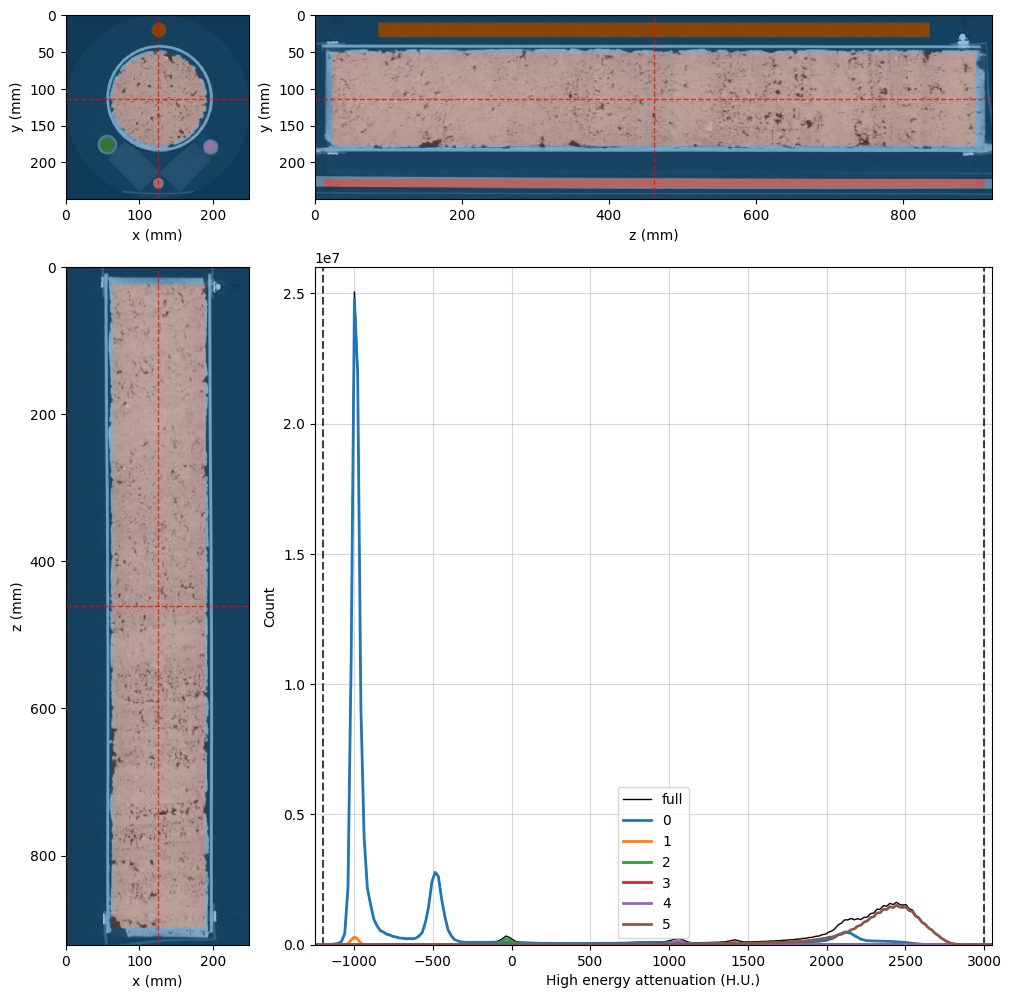

In [9]:
%%px --block

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)     # Air will be phase 1
dectgroup.segmentation.math(value=2, op='set', region=water_region)   # Water will be phase 2
dectgroup.segmentation.math(value=3, op='set', region=silica_region)  # Silica will be phase 3
dectgroup.segmentation.math(value=4, op='set', region=teflon_region)  # Teflon will be phase 4
dectgroup.segmentation.math(value=5, op='set', region=rock_region)    # Rock sample will be phase 5

# Adjust the viewer and display for rank 0
highE_viewer.region = None
highE_viewer.segmentation = dectgroup.segmentation
highE_viewer.ref_point = rock_region.p
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2.6e7)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)

## Assigning the mask image

Our segmentation result conveniently delivers the inversion mask (voxels we want to exclude from our inversion) through segmentation phase 0. Let's assign it to our dect group:

[stdout:0] [2025-08-08 11:05:32] (mask) Set: 100% 16/16 [00:00<00:00, 34.71chunk/s]
[2025-08-08 11:05:33] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 39.79chunk/s]
[2025-08-08 11:05:33] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 453.24chunk/s]
[2025-08-08 11:05:33] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:00<00:00, 17.86chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

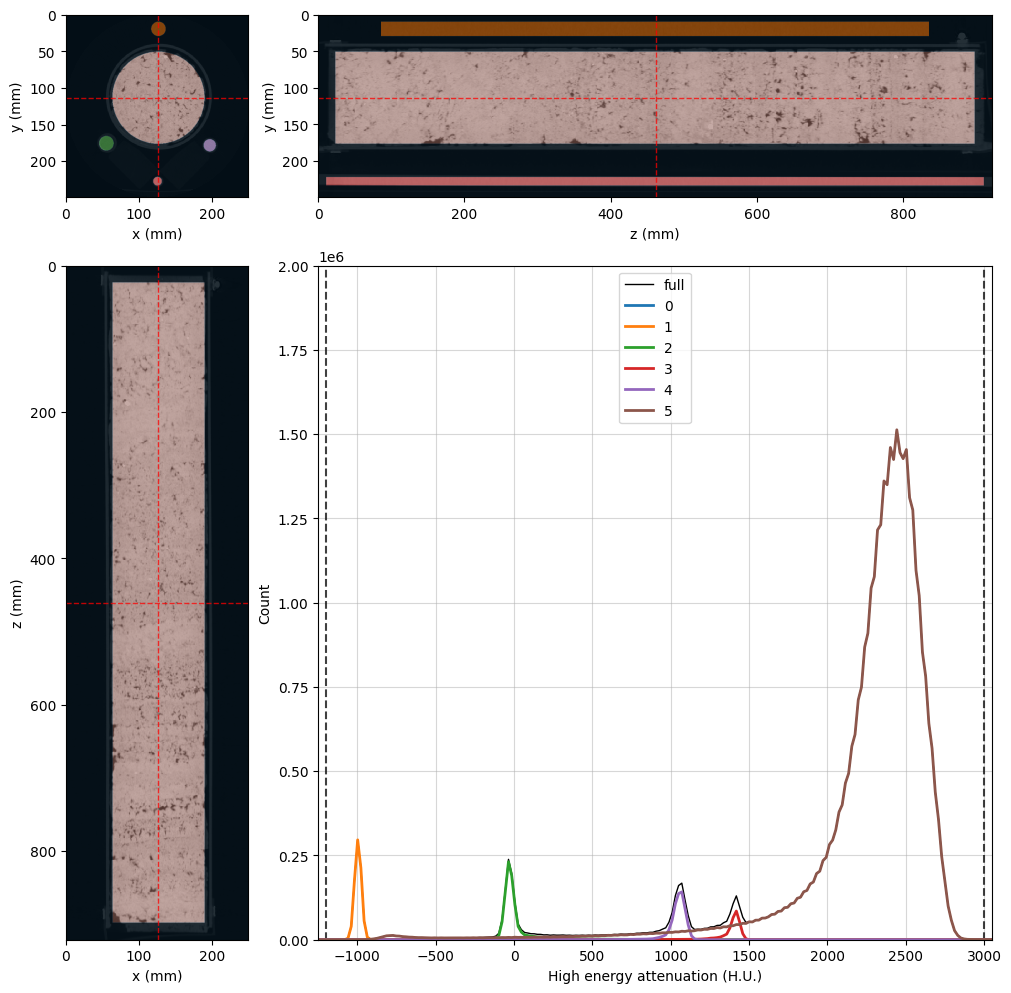

In [10]:
%%px --block

# Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

# Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

# Adjust the viewer and display for rank 0
highE_viewer.mask = dectgroup.mask
highE_viewer.mask_color = 'k'
highE_viewer.mask_alpha = 0.75
highE_viewer.ax_histogram.set_xlim(-1250, 3050)
highE_viewer.ax_histogram.set_ylim(0, 2e6)

if rv.mpi_rank == 0:
    display(highE_viewer.figure)


The black voxels in the image above will be ignored during the Monte Carlo inversion. Let's rebuild both viewers with all the updates so far. This time we will increase the number of histogram bins and write proper labels for the segmentation phases.

[stdout:0] [2025-08-08 11:05:40] Histogram Low energy attenuation (min/max): 100% 16/16 [00:00<00:00, 63.18chunk/s]
[2025-08-08 11:05:41] Histogram Low energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 491.79chunk/s]
[2025-08-08 11:05:41] Histogram Low energy attenuation (counting voxels): 100% 16/16 [00:03<00:00,  5.04chunk/s]
[2025-08-08 11:05:49] Histogram High energy attenuation (min/max): 100% 16/16 [00:00<00:00, 60.33chunk/s]
[2025-08-08 11:05:49] Histogram High energy attenuation (reading segmentation): 100% 16/16 [00:00<00:00, 458.55chunk/s]
[2025-08-08 11:05:49] Histogram High energy attenuation (counting voxels): 100% 16/16 [00:02<00:00,  5.34chunk/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

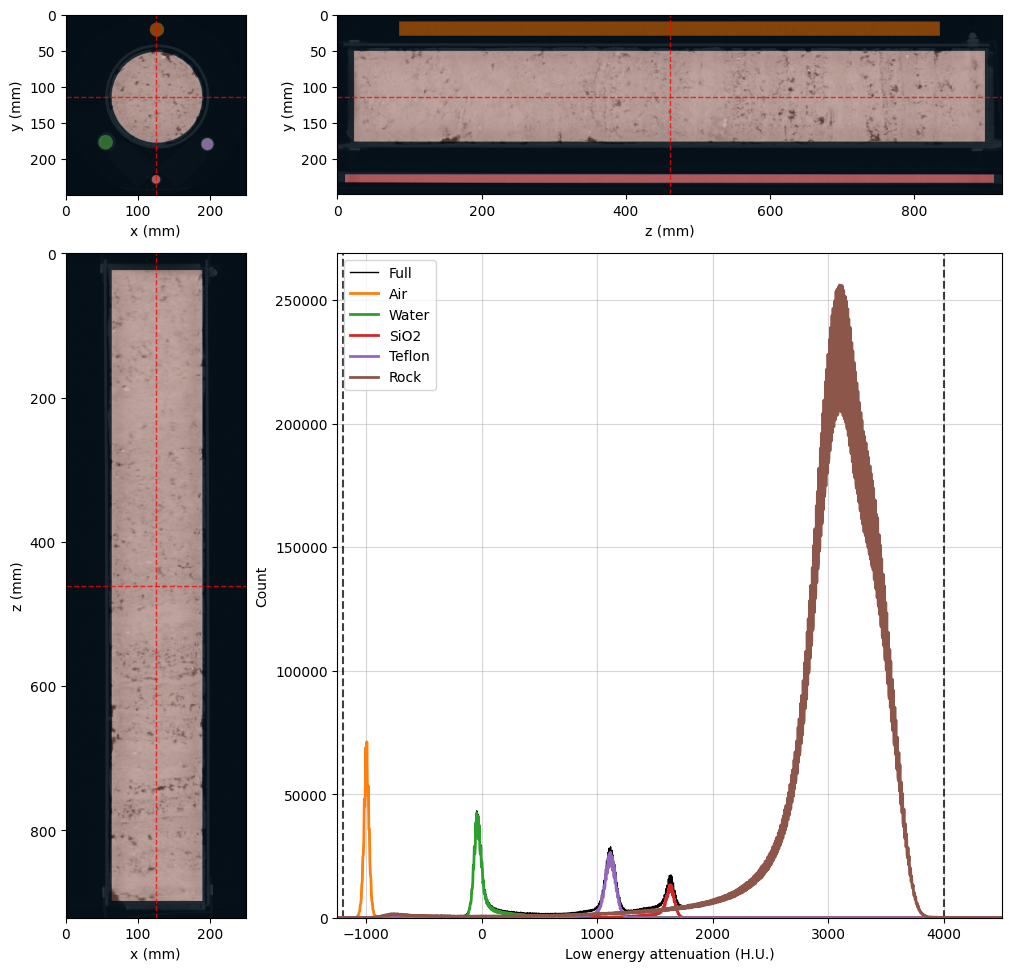

[output:0]

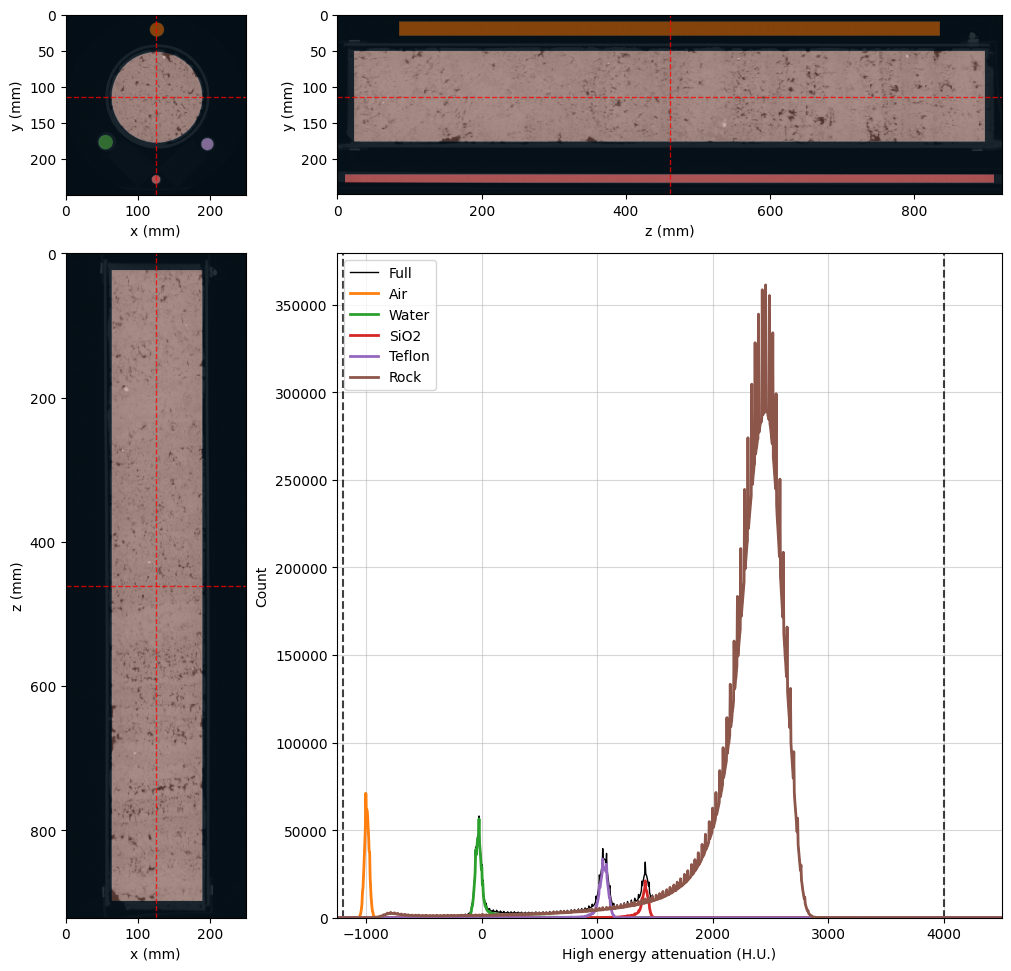

In [11]:
%%px --block

# Common properties can be set at once at OrthogonalViewer creation
kwargs = {
    'region': None,
    'mask': dectgroup.mask,
    'mask_color': 'k',
    'mask_alpha': 0.75,
    'histogram_bins': 5000,
    'segmentation': dectgroup.segmentation,
    'ref_point': rock_region.p,
}

lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, **kwargs)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, **kwargs)

# Fine tuning viewer properties
for viewer in [lowE_viewer, highE_viewer]:
    viewer.figure.set_size_inches(10, 10)    # figure size
    viewer.update_image_dict(clim=(-1200, 4000)) # X-ray CT clims
    viewer.ax_histogram.set_xlim(-1250, 4500)  # Histogram limits
    # Set segmentation names in the legend labels
    viewer.ax_histogram.legend(
        [
            highE_viewer.histogram_lines['full'],
            highE_viewer.histogram_lines['1'],
            highE_viewer.histogram_lines['2'],
            highE_viewer.histogram_lines['3'],
            highE_viewer.histogram_lines['4'],
            highE_viewer.histogram_lines['5'],
        ], [
            'Full',
            'Air',
            'Water',
            'SiO2',
            'Teflon',
            'Rock'
        ]
    )

# Close all but rank 0
if rv.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)


## Filling Standard Material Information and running pre-process

Now we can finally populate the information and the X-ray attenuation probability density functions (PDFs) for the standard materials. There are two ways to inform RockVerse about these PDFs:

   1. By passing a two-element list or tuple containing the x (attenuation values) and y (PDF values) as Numpy arrays for an arbitrary PDF model. Input PDF values do not need to be normalized, as RockVerse will handle the normalization when assigning the values. 
   2. By passing a tuple with mean and standard deviation for a gaussian (normal) model. 

### Passing the PDFs as x, y arrays 

In our case, the simplest (although not very accurate...) way is to use option 1 with the segmentation histograms we have already calculated in the orthogonal viewers
(ensure you have a high number of bins to avoid inversion errors due to histogram interpolation).
Let's try this first: 

In [12]:
%%px --block

dectgroup.calibration_material[0].description = 'Air'
dectgroup.calibration_material[0].lowE_pdf = (
    lowE_viewer.histogram.bin_centers, lowE_viewer.histogram.count[1].values)
dectgroup.calibration_material[0].highE_pdf = (
    highE_viewer.histogram.bin_centers, highE_viewer.histogram.count[1].values)

dectgroup.calibration_material[1].description = 'Water'
dectgroup.calibration_material[1].bulk_density = 1.0
dectgroup.calibration_material[1].composition = {'H': 2, 'O': 1}
dectgroup.calibration_material[1].lowE_pdf = (
    lowE_viewer.histogram.bin_centers, lowE_viewer.histogram.count[2].values)
dectgroup.calibration_material[1].highE_pdf = (
    highE_viewer.histogram.bin_centers, highE_viewer.histogram.count[2].values)

dectgroup.calibration_material[2].description = 'SiO2'
dectgroup.calibration_material[2].bulk_density = 2.2
dectgroup.calibration_material[2].composition = {'Si': 1, 'O': 2}
dectgroup.calibration_material[2].lowE_pdf = (
    lowE_viewer.histogram.bin_centers, lowE_viewer.histogram.count[3].values)
dectgroup.calibration_material[2].highE_pdf = (
    highE_viewer.histogram.bin_centers, highE_viewer.histogram.count[3].values)

dectgroup.calibration_material[3].description = 'Teflon'
dectgroup.calibration_material[3].bulk_density = 2.2
dectgroup.calibration_material[3].composition = {'C': 2, 'F': 4}
dectgroup.calibration_material[3].lowE_pdf = (
    lowE_viewer.histogram.bin_centers, lowE_viewer.histogram.count[4].values)
dectgroup.calibration_material[3].highE_pdf = (
    highE_viewer.histogram.bin_centers, highE_viewer.histogram.count[4].values)

There is a special function in the DECTGroup class for quick PDF visualization:

[output:0]

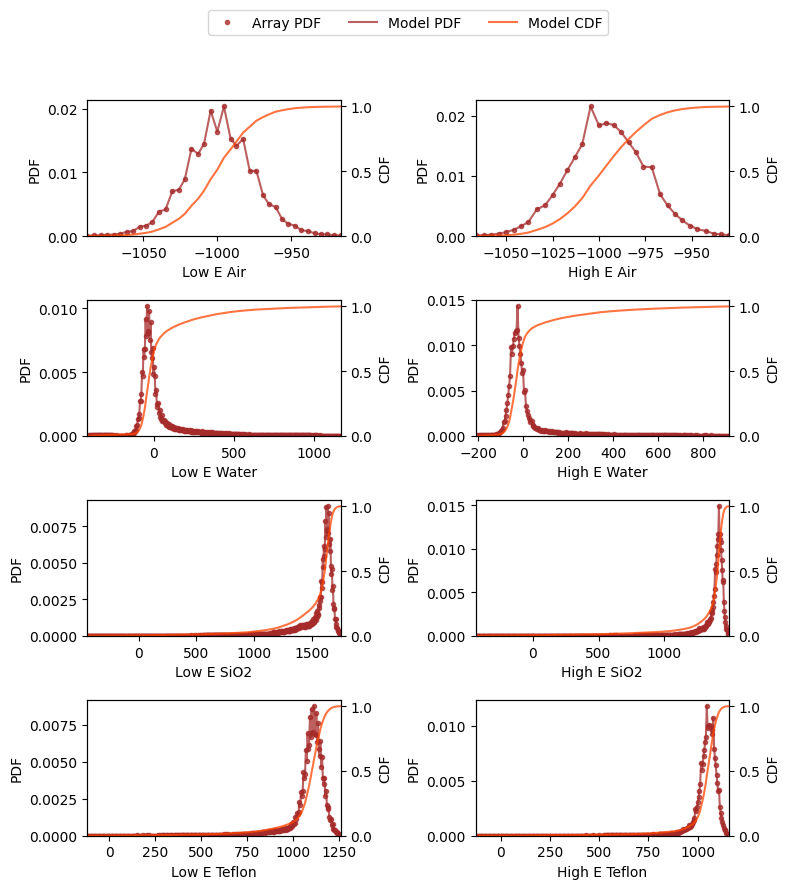

In [13]:
%%px --block

fig, _ = dectgroup.view_pdfs(bins=30, percentile_interval=(0.1, 99.9), plot_cdfs=True)

# Close all but rank 0
if rv.mpi_rank != 0:
    plt.close(fig)

### Run the Preprocessing Step

Pre-processing will check all the necessary details in the `dectgroup` and pre-calculate the dual energy inversion coefficients $A$, $B$, and $n$ for low and high energy. Additionally, this step verifies all the internal hash values to ensure simulation integrity, which is crucial for resuming any interrupted simulations.

The simulations are controlled by the following parameters:
- `maxA`: Maximum search value for inversion coefficient $A$. 
- `maxB`: Maximum search value for inversion coefficient $B$.
- `maxn`: Maximum value for inversion coefficient $n$.
- `tol`: Tolerance value for terminating the Newton-Raphson optimizations.
- `whis`: The boxplot whisker length for determining Monte Carlo outlier results.
- `required_iterations`: The required number of valid Monte Carlo iterations for each voxel.
- `maximum_iterations`: The maximum number of trials to get valid Monte Carlo iterations per voxel.
- `threads_per_block`: The number of threads per block when processing using GPUs, which can optimize performance based on available hardware.

RockVerse has default values for these parameters, which you can get or set using the corresponding properties (see the API documentation for more details):
- `dectgroup.maxA`
- `dectgroup.maxB`
- `dectgroup.maxn`
- `dectgroup.tol`
- `dectgroup.whis`
- `dectgroup.required_iterations`
- `dectgroup.maximum_iterations`
- `dectgroup.threads_per_block`

Let's call the ``preprocess`` method:

In [14]:
%%px --block
dectgroup.preprocess()

[stdout:0] [2025-08-08 11:06:05] Hashing Low energy attenuation: 100% 16/16 [00:00<00:00, 75.62chunk/s]
[2025-08-08 11:06:06] Hashing High energy attenuation: 100% 16/16 [00:00<00:00, 72.98chunk/s]
[2025-08-08 11:06:06] Hashing mask: 100% 16/16 [00:00<00:00, 241.17chunk/s]
[2025-08-08 11:06:06] Hashing segmentation: 100% 16/16 [00:00<00:00, 253.23chunk/s]
[2025-08-08 11:06:06] Generating inversion coefficients: 100% 100000/100000 [00:10<00:00, 9163.42/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

### Pre-process appraisal

It is important to check consistency between the generated coefficients and the expected PDFs before launching the full inversion.
The pre-calculated inversion coefficients can be accessed through the following attributes:
   - ``lowE_inversion_coefficients``
   - ``highE_inversion_coefficients``

Let's take a look:

In [15]:
%%px --block

# ATTENTION: Assigning/retrieving information from the dect group is a collective MPI call.
# Ensure all processes make the call when running in a parallel environment.
lowEcoefs = dectgroup.lowE_inversion_coefficients

# Now we can print from only rank 0
if rv.mpi_rank == 0:
    print('Low energy inversion coefficients\n', lowEcoefs)


[stdout:0] Low energy inversion coefficients
          CT_0  CT_1    CT_2    CT_3       Z_1        Z_2       Z_3  \
0     -1005.0  31.0  1654.5  1202.5  6.548783  10.775734  8.243564   
1      -991.0   4.0  1628.0  1110.5  6.844545  10.936677  8.285364   
2     -1005.0 -34.5  1619.0  1110.5  6.575004  10.788002  8.246824   
3     -1018.0 -56.5  1658.0  1154.0  6.282562  10.666381  8.213902   
4      -978.0 -70.0  1601.5  1070.0  6.448862  10.731694  8.231752   
...       ...   ...     ...     ...       ...        ...       ...   
49995 -1018.0 -12.5  1527.0  1136.5  6.322791  10.681383  8.218038   
49996 -1021.5 -39.0  1614.0  1000.5  7.226754  11.272998  8.367188   
49997  -934.0  13.5  1685.0  1013.0  7.318996  11.396976  8.395941   
49998  -943.0 -21.5  1619.0  1057.0  6.788347  10.901663  8.276440   
49999 -1013.0  57.5  1443.0  1079.5  7.408483  11.545368  8.429642   

                A           B         n           err  
0      469.564260   79.015625  0.941553  2.542115e-13  
1

The ``view_pdfs`` method we used before will show the corresponding histograms when the inversion coefficients have been calculated:

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

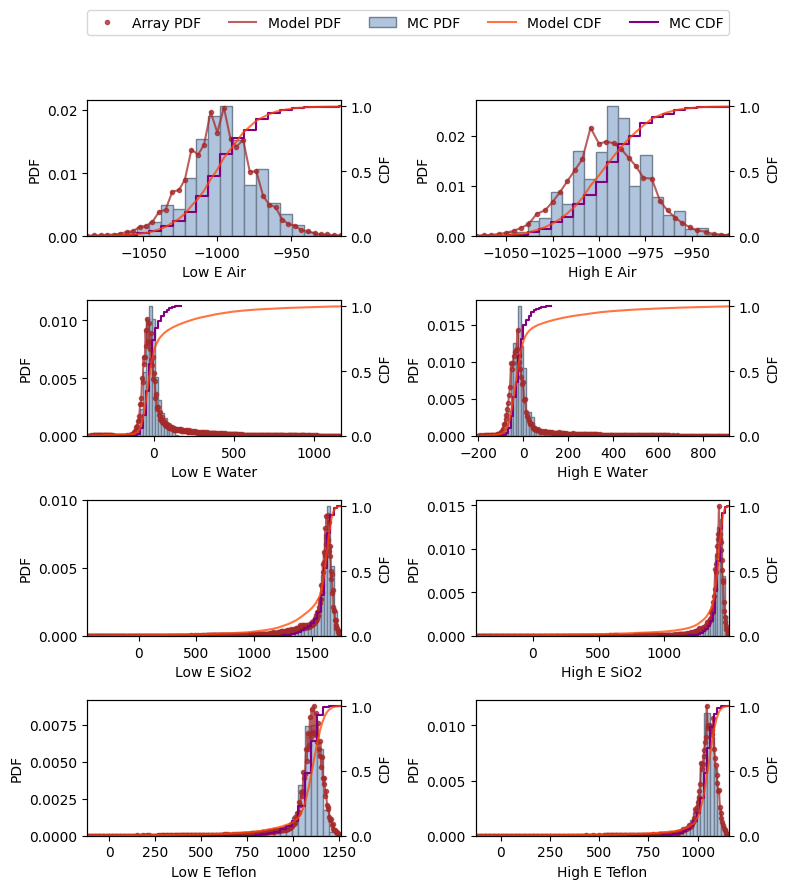

In [16]:
%%px --block

fig, _ = dectgroup.view_pdfs(bins=30, percentile_interval=(0.1, 99.9), plot_cdfs=True)

# Close all but rank 0
if rv.mpi_rank != 0:
    plt.close(fig)

Note the long tails in the input PDFs, a result of segmentation phase for water touching the water pipe area and 
segmentation phases for SiO<sub>2</sub> and Teflon slightly overlapping with the empty region.
This can be improved by using Gaussian models for the PDFs.

## Passing mean and variance for Gaussian PDF Models

The second form to pass a PDF model to the dect group is to provide the mean and standard deviation of a Gaussian (normal) distribution. 
If you have these values from some other analysis, you can manually pass a tuple containing the corresponding
values ``(mu, sigma)`` to the Gaussian PDF attributes:

```python
dectgroup.calibration_material[0].lowE_gaussian_pdf = (mu_0_l, sigma_0_l)
dectgroup.calibration_material[0].highE_gaussian_pdf = (mu_0_h, sigma_0_h)

dectgroup.calibration_material[1].lowE_gaussian_pdf = (mu_1_l, sigma_1_l)
dectgroup.calibration_material[1].highE_gaussian_pdf = (mu_1_h, sigma_1_h)

dectgroup.calibration_material[2].lowE_gaussian_pdf = (mu_2_l, sigma_2_l)
dectgroup.calibration_material[2].highE_gaussian_pdf = (mu_2_h, sigma_2_h)

dectgroup.calibration_material[3].lowE_gaussian_pdf = (mu_3_l, sigma_3_l)
dectgroup.calibration_material[3].highE_gaussian_pdf = (mu_3_h, sigma_3_h)
```

Gaussian PDF models take precedence over the PDF arrays when calculating the inversion coefficients.
To delete Gaussian PDF models, set the corresponding attributes to ``None``.

```python
dectgroup.calibration_material[0].lowE_gaussian_pdf = None
```

RockVerse has a convenience method to call the ``gaussian_fit`` function from its optimization module and 
fit Gaussian distributions to the assigned ``lowE_pdf`` and ``highE_pdf`` values:

In [17]:
%%px --block

dectgroup.calibration_material[0].fit_lowE_gaussian_pdf()
dectgroup.calibration_material[0].fit_highE_gaussian_pdf()

dectgroup.calibration_material[1].fit_lowE_gaussian_pdf()
dectgroup.calibration_material[1].fit_highE_gaussian_pdf()

dectgroup.calibration_material[2].fit_lowE_gaussian_pdf()
dectgroup.calibration_material[2].fit_highE_gaussian_pdf()

dectgroup.calibration_material[3].fit_lowE_gaussian_pdf()
dectgroup.calibration_material[3].fit_highE_gaussian_pdf()

# Let's print one of the values just for checking
# Remember all processes have to call operations on the dectgroup
mu, sigma = dectgroup.calibration_material[3].highE_gaussian_pdf
name = dectgroup.calibration_material[3].description

# Now we can print from only rank 0
if rv.mpi_rank == 0:
    print(f'Gaussian model for {name.lower()} low energy attenuation: mu={mu:.4f}, sigma={sigma:.4f}.')


[stdout:0] Gaussian model for teflon low energy attenuation: mu=1056.8979, sigma=35.6190.


Another call to ``view_pdfs`` will show the Gaussian models as well:

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

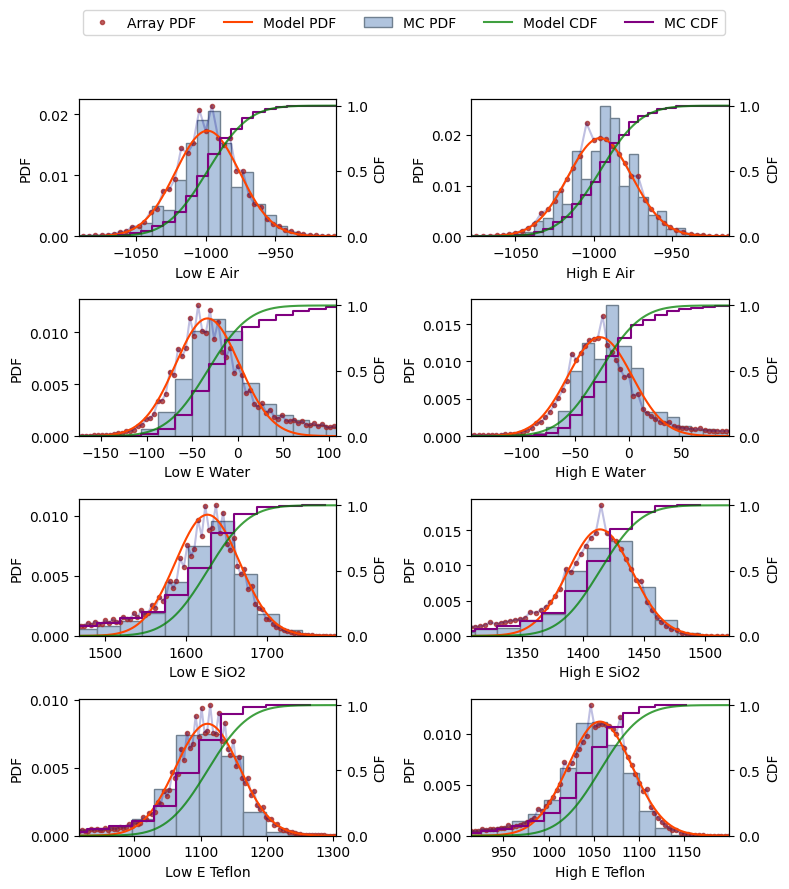

In [18]:
%%px --block

fig, _ = dectgroup.view_pdfs(bins=30, percentile_interval=(0.1, 99.9), plot_cdfs=True)

# Close all but rank 0
if rv.mpi_rank != 0:
    plt.close(fig)

Let's call the ``preprocess`` again to generate a new set of inversion coefficients. RockVerse will prioritize the Gaussian models over the ``lowE_pdf`` and ``highE_pdf`` attributes.

[stdout:0] [2025-08-08 11:06:24] Hashing Low energy attenuation: 100% 16/16 [00:00<00:00, 72.90chunk/s]
[2025-08-08 11:06:24] Hashing High energy attenuation: 100% 16/16 [00:00<00:00, 75.01chunk/s]
[2025-08-08 11:06:24] Hashing mask: 100% 16/16 [00:00<00:00, 251.23chunk/s]
[2025-08-08 11:06:24] Hashing segmentation: 100% 16/16 [00:00<00:00, 259.79chunk/s]
[2025-08-08 11:06:24] Generating inversion coefficients: 100% 100000/100000 [00:02<00:00, 47645.63/s]


%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[output:0]

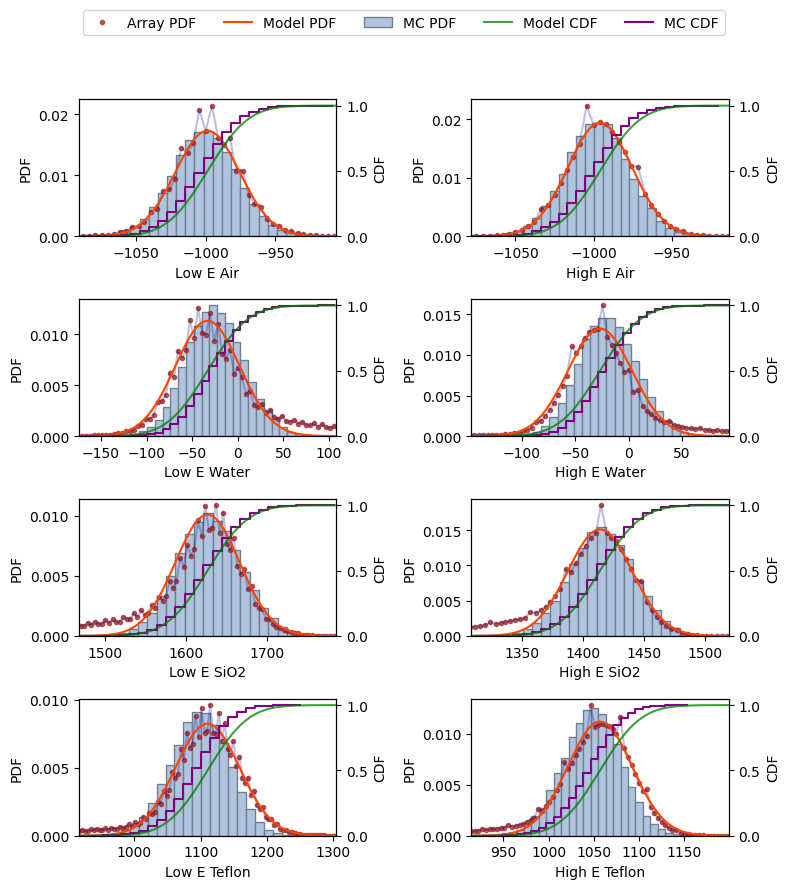

In [19]:
%%px --block
dectgroup.preprocess(restart=True)

fig, _ = dectgroup.view_pdfs(bins=30, percentile_interval=(0.1, 99.9), plot_cdfs=True)

# Close all but rank 0
if rv.mpi_rank != 0:
    plt.close(fig)

This concludes our data preparation. There are also convenience functions for quick visualization of the inversion coefficients and the resulting $Z_{eff}$:

[output:0]

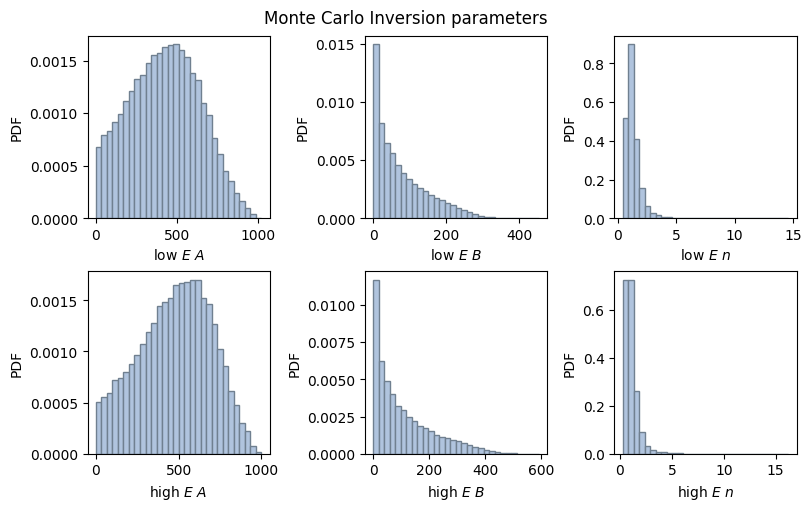

In [20]:
%%px --block

fig, _ = dectgroup.view_inversion_coefs()

if rv.mpi_rank != 0:
    plt.close(fig)

[output:0]

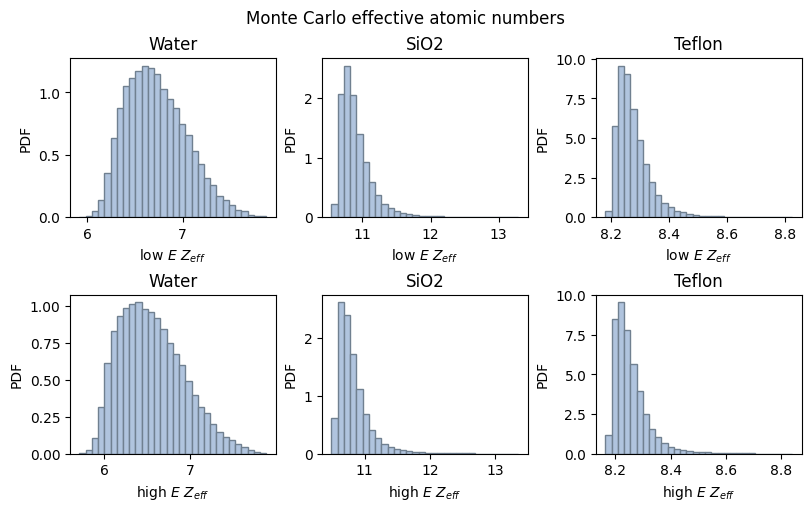

In [21]:
%%px --block

fig, _ = dectgroup.view_inversion_Zeff()

if rv.mpi_rank != 0:
    plt.close(fig)


The tails in these histograms indicate that we have adequately captured the distributions, and therefore we have reasonable values for the `maxA`, `maxB`, and `maxn` attributes. If you notice truncated tails on the right side of the histograms, consider rerunning the preprocess function after increasing those maximum values.

That is the end of this part of the tutorial. We can now stop the cluster and proceed to the next part.

In [22]:
cluster.stop_cluster()

<coroutine object Cluster.stop_cluster at 0x7f3084547c60>